In [1]:
# Source helper fn file
from scripts.contextualize import *
from scripts.dict_to_dtm import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from scripts.contextualize import * # defines contextualize_all
from scipy.sparse import coo_matrix
from scripts.dict_to_dtm import * # Defines dict_to_dtm()
#from lda import LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Define a helper function to plot the top words
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, len(model.components_), figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [2]:
keep_words

['below',
 'above',
 'over',
 'under',
 'most',
 'more',
 'should',
 'now',
 'up',
 'down']

In [3]:
transcript_1 = pd.read_csv("transcript.csv", index_col = None)
txt = transcript_1.text.values[0]
txt

"welcome back to another meet kevin report today is a saturday february 4th and boy we have a lot to cover in today's not only are we going to talk about a cpi shocker coming up but we've got to talk about this chinese spy balloon we're going to talk about tesla and ford what are the ceo of ford just say that was probably the most ludicrous thing that i could possibly imagine and it was hilarious you're gonna love it the earnings call was great i've got the breakdown for you we'll talk about uh what hedge funds are up to what's going on with the federal reserve as well as a bunch of other things so a lot to cover let's get into it first we got to talk about a coming cpi shock because the initial estimates for january's cpi from economists are out and remember the next inflation report isn't until february 14th between then now we've got a few catalysts to go through so what i'll do is i'll hit what some of these catalysts are going to be in the coming couple weeks here coming 10 days a

In [4]:
# Use custom functions to create documents from the words surrounding targets
ford_context = contextualize_all(txt, 'ford', 10)
tesla_context = contextualize_all(txt, 'tesla', 10)

In [5]:
ford_context.head()

,target,window_size,location,before,after
0,ford,10,30,balloon we're going talk tesla,ceo ford say probably most
1,ford,10,32,going talk tesla ford ceo,say probably most ludicrous thing
2,ford,10,4630,baby elon elongate uh elon,oh going fun one elon
3,ford,10,4637,going fun one elon musk,oh boy we've got lot
4,ford,10,4653,elon musk got results lawsuit,insane things say boy gonna


In [6]:
tesla_context.head()

,target,window_size,location,before,after
0,tesla,10,29,spy balloon we're going talk,ford ceo ford say probably
1,tesla,10,4660,things say boy gonna make,people nervous we'll talk video
2,tesla,10,4668,we'll talk video first musk,sued potential damages high 6
3,tesla,10,4683,musk's august 2018 tweet taking,private 4 20. sec alleged
4,tesla,10,4720,handshake deal would help buy,even though later confusion backtracking


In [7]:
# Convert to like:
# ford_content = [
#     'This is the text before instance 1 This is the text after instance 1',
#     'This is the text before instance 2 This is the text after instance 2',
#     'This is the text before instance 3 This is the text after instance 3',
#     ...
#     'This is the text before instance n This is the text after instance n'
# ]
ford_content = ford_context[['before', 'after']].apply(lambda row: ' '.join([row[0], row[1]]), axis=1).tolist()
tesla_content = tesla_context[['before', 'after']].apply(lambda row: ' '.join([row[0], row[1]]),axis=1).tolist()

In [8]:
# Word tokenize each row and then join, retain unique
ford_vocab = (' '.join(ford_content)).split(' ')
ford_vocab = np.unique(ford_vocab).tolist() # it's already sorted too
# Repeat for tesla
tesla_vocab = (' '.join(tesla_content)).split(' ')
tesla_vocab = np.unique(tesla_vocab).tolist()

In [9]:
# For this special use-case, drop the target words around which we built context
ford_vocab.pop(ford_vocab.index('ford'))
ford_vocab.pop(ford_vocab.index('tesla'))
tesla_vocab.pop(tesla_vocab.index('tesla'))
tesla_vocab.pop(tesla_vocab.index('ford'))

'ford'

In [10]:
# Create the document term matrix for each, skipping ford and tesla
ford_dtm = np.zeros((len(ford_content), len(ford_vocab)))
for doc_idx, doc in enumerate(ford_content):
    for word in doc.split(' '):
        if word not in ['ford', 'tesla']:
            ford_dtm[doc_idx, ford_vocab.index(word)] += 1
tesla_dtm = np.zeros((len(tesla_content), len(tesla_vocab)))
for doc_idx, doc in enumerate(tesla_content):
    for word in doc.split(' '):
        if word not in ['ford', 'tesla']:
            tesla_dtm[doc_idx, tesla_vocab.index(word)] += 1

In [11]:
# Fit lda models
lda = LDA(n_components=3, random_state=0)
ford_lda_3 = lda.fit(ford_dtm)
lda = LDA(n_components=3, random_state=0)
tesla_lda_3 = lda.fit(tesla_dtm)

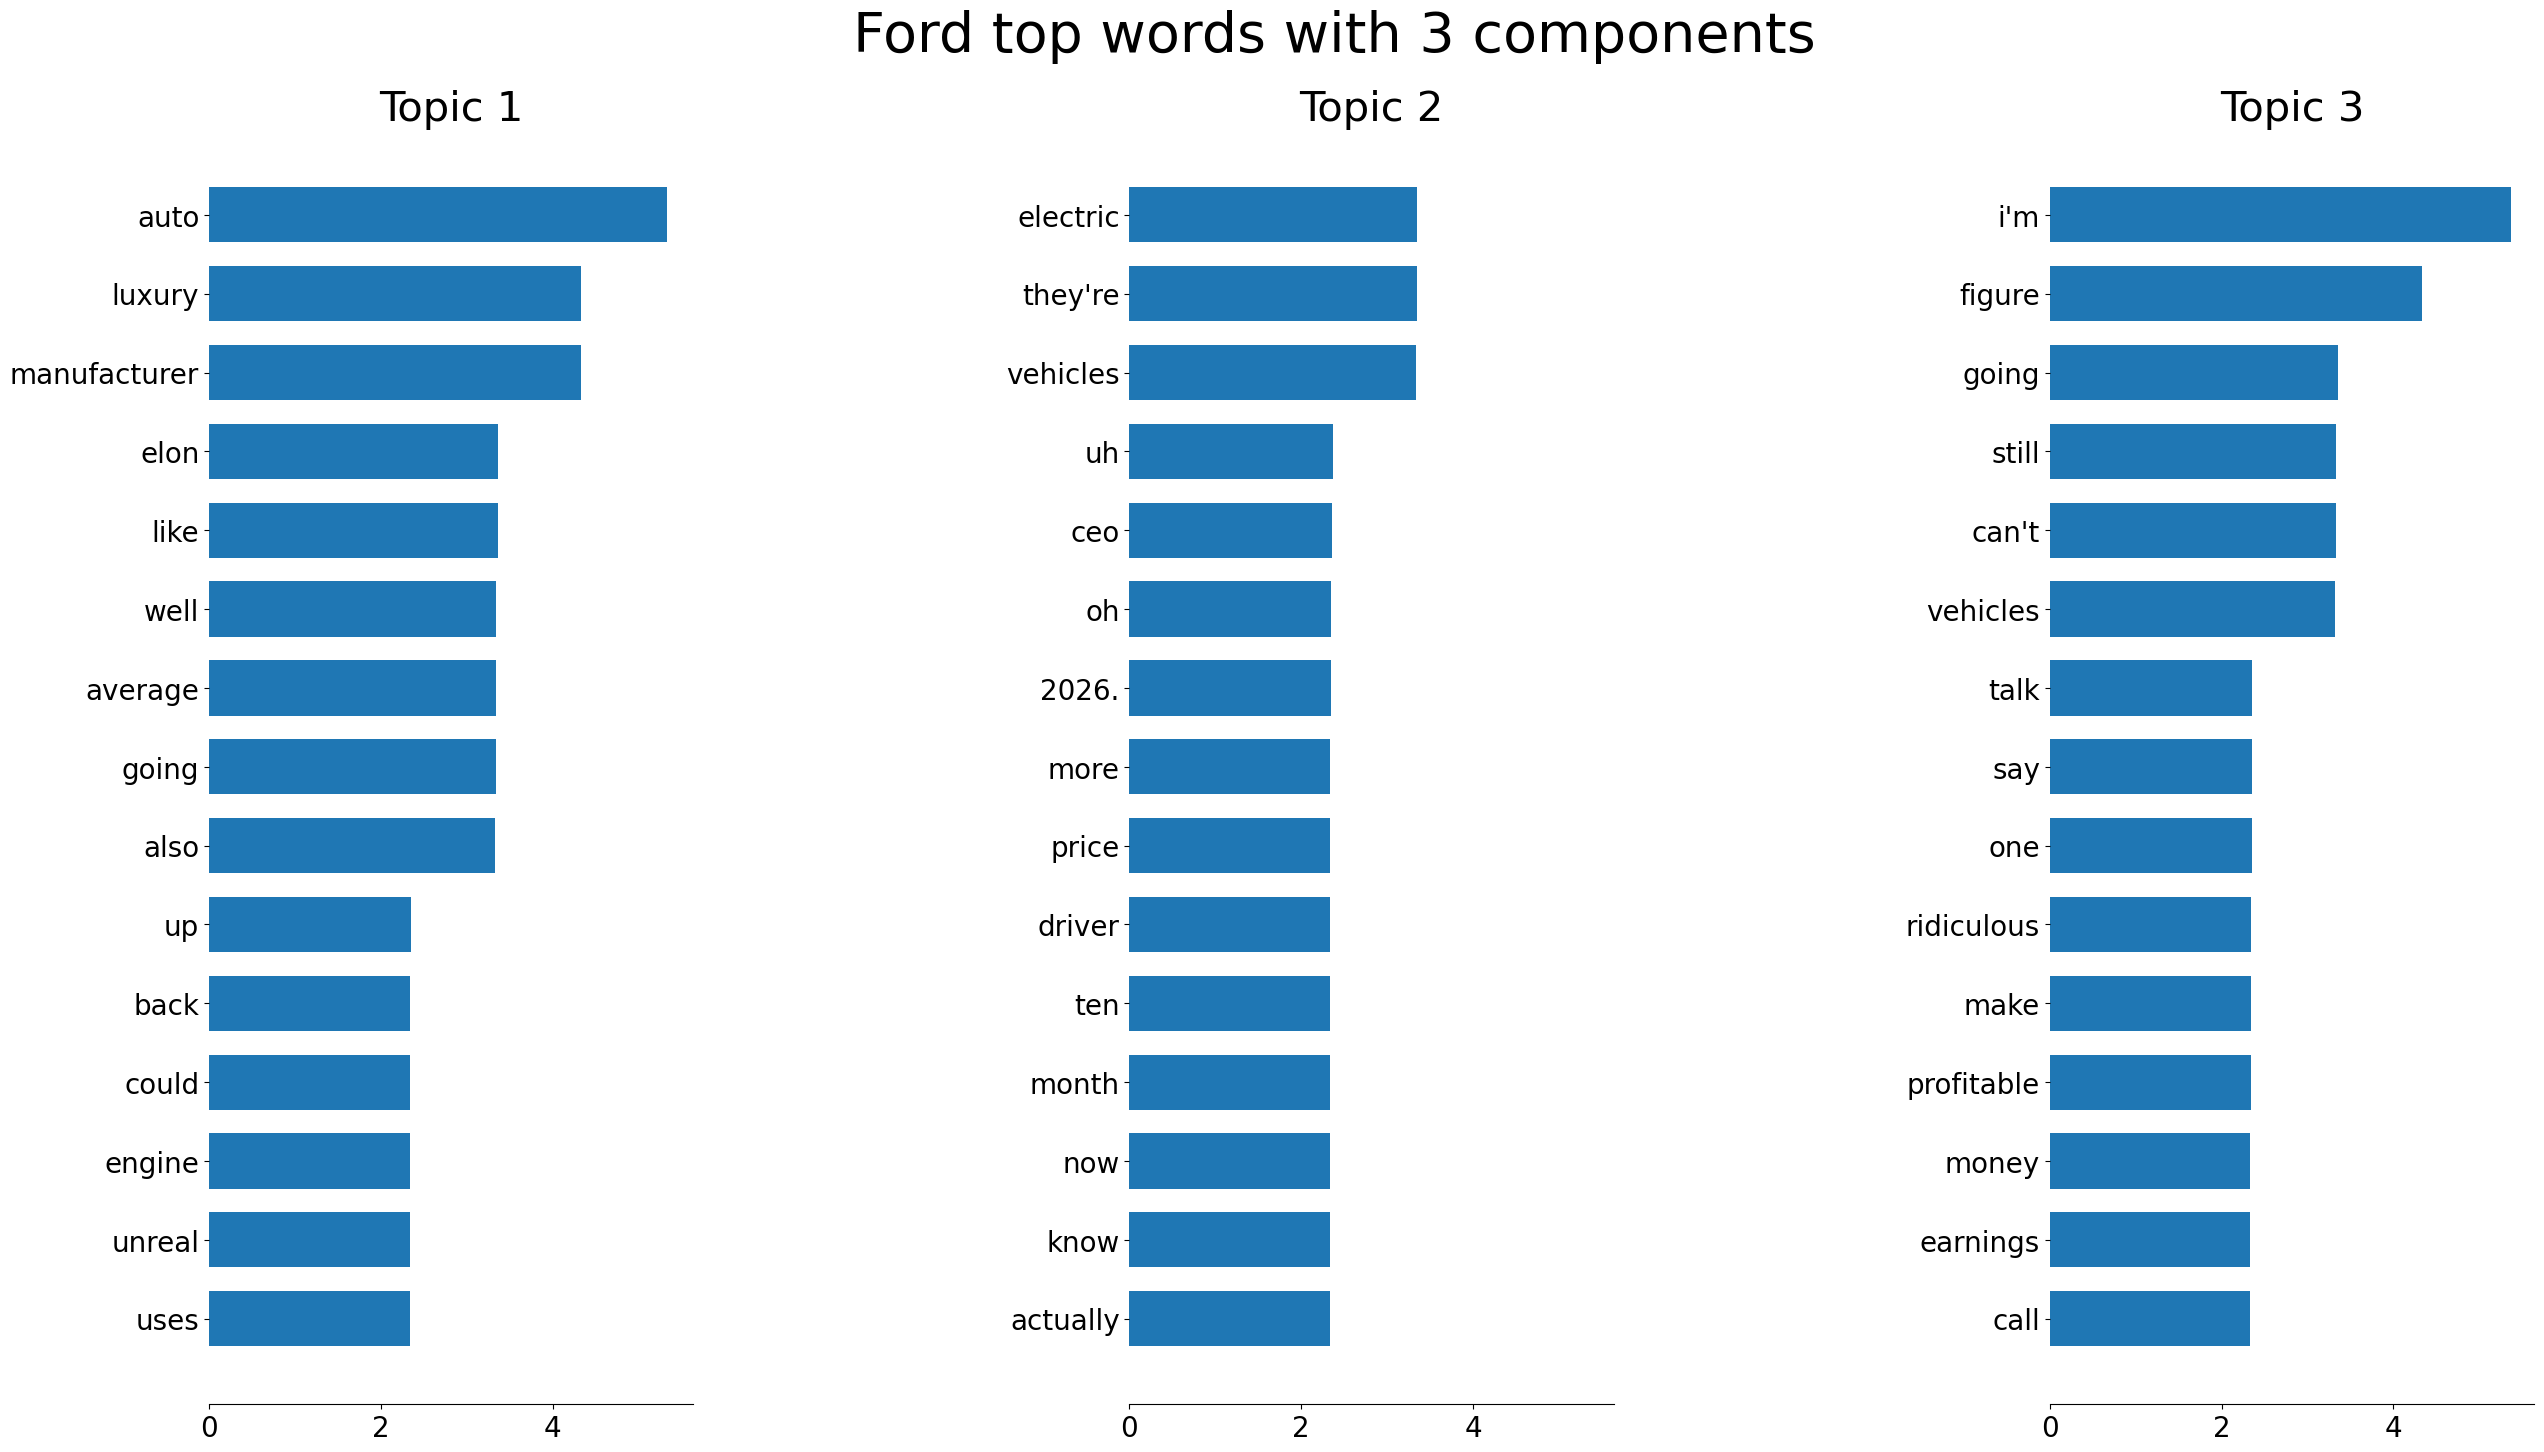

In [12]:
plot_top_words(ford_lda_3, np.array(ford_vocab), 15, 'Ford top words with 3 components')